In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K 

# Helper libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# From the tutorial
# https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


def s(x):
    
    "Activation function to implement the basis functions"
    
    y0 = K.switch(tf.logical_and(tf.zeros(tf.shape(x))<=x, x<tf.ones(tf.shape(x))), 
                 x**3/6, 
                 tf.zeros(tf.shape(x))
                )
    
    y1 = K.switch(tf.logical_and(tf.ones(tf.shape(x))<=x, x<2*tf.ones(tf.shape(x))),
                 (-3.*(x-1.)**3 +3.*(x-1.)**2 + 3*(x-1.)+1.)/6.,
                 tf.zeros(tf.shape(x))
                )
    
    y2 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*2<=x, x<3*tf.ones(tf.shape(x))),
                 (3*(x-2)**3 - 6*(x-2)**2 + 4. )/6.,
                 tf.zeros(tf.shape(x))
                )

    y3 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*3<=x, x<4*tf.ones(tf.shape(x))),
                 ( 4. -x)**3/6.,
                 tf.zeros(tf.shape(x))
                )    
    
    y  = y0 + y1 + y2 + y3
    
    return y


def partition_weights(n,n0):
    p0 = n0*n
    y = np.zeros((n,p0))
    for i in range(n):
        y[i,i*n0:(i+1)*n0] = 1.
    return y 

def partition_bias(n,n0):
    p0 = n0*n
    return (np.arange(0.,p0)%n0)    

def spline_function_(n,m,c0,u0):
    """
    Function from [0,1]^n to R^m
    n  - Input dimension
    m  - output dimension
    c0 - the capacity of the network, the number of control points for each input variable is proportional capacity
    u0 - the initial value of all control points
    """
    
    d0 = 3 
 
    n0 = c0 + d0 # the number of control points; capacity + degree of basis function
    p0 = n0*n

    w0 = tf.constant_initializer(c0*partition_weights(n,n0))
    b0 = tf.constant_initializer(d0 - partition_bias(n,n0))
    
    w1 = tf.constant_initializer(u0)

    inn = tf.keras.layers.Input(shape=(n,))

    l00 = tf.keras.layers.Dense(activation=s3,
                                units=p0,
                                use_bias=True,
                                trainable=False,
                                kernel_initializer=w0,
                                bias_initializer=b0 
                               )(inn)          # Modified
    
    out = tf.keras.layers.Dense(units=m,
                                use_bias=False,
                                trainable=True,
                                kernel_initializer=w1
                               )(l00)

    model = tf.keras.Model(inputs=inn, 
                           outputs= out
                          )
    return model

def partition_weights_2(n,r):
    d0 = float(3)
    l0 = 4*(2**np.arange(0,r))
    l1 = [(x-d0)*partition_weights(n,x) for x in l0]
    l2 = np.concatenate(l1,axis=1)
    return l2

def partition_bias_2(n,r):
    d0 = float(3)
    l0 = 4*(2**np.arange(0,r))
    l1 = [d0 - partition_bias(n,x) for x in l0]
    l2 = np.concatenate(l1,axis=0)
    return l2


TensorFlow version:  2.1.0


In [2]:
class Memory_Regularizer(tf.keras.regularizers.Regularizer):
    
    def __init__(self, h0=0.,weight_memory = 0.):
        self.h0 = h0
        self.weight_memory = weight_memory
        
    def __call__(self, x):
        #self.l2 * tf.math.reduce_sum(tf.math.square(x))
        #self.h0 * tf.math.reduce_sum(tf.math.abs(x-self.weight_memory))
        return self.h0 * tf.math.reduce_sum(tf.math.square(x-self.weight_memory))
    
    def get_config(self):
        
        return {'h0': float(self.h0)}

In [3]:
class typical_ann(keras.Model):
    """ """
    def __init__(self, n, m, r, k, h):
        super(typical_ann, self).__init__()
        
        #tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        #tf.constant_initializer(0.)
        
        self.n = n
        self.m = m
        self.r = r
        self.k = k
        #self.h = h
        
        self.memory_regulizer_f11 = Memory_Regularizer(h0=h,weight_memory=0.)
        self.memory_regulizer_f02 = Memory_Regularizer(h0=h,weight_memory=0.)
        self.memory_regulizer_f55 = Memory_Regularizer(h0=h,weight_memory=0.)
        
        
        self.f01 = tf.keras.layers.Dense(activation=s,
                                     name='OSAM_P0',
                                     units=n*((4*(2**np.arange(0,r))).sum()),
                                     use_bias=True,
                                     trainable=True)
        
        self.f11 = tf.keras.layers.Dense(units=m,
                                     name='OSAM_F0',
                                     use_bias=False,
                                     trainable=True)
        
        self.f02 = tf.keras.layers.Dense(activation=None,
                                         name='Inner_Functions',
                                         units=k,
                                         use_bias=False,
                                         trainable=True)
        
        self.f22 = tf.keras.layers.Dense(activation=None,
                                         name='Projected_Inner_Res',
                                         units=m,
                                         use_bias=False,
                                         trainable=True)
        
        self.f03 = tf.keras.layers.Activation(tf.nn.sigmoid,name='Sigmoid')
        
        self.f04 = tf.keras.layers.Dense(activation=s,
                                         name='Outer_OSAM_P0',
                                         units=k*((4*(2**np.arange(0,r))).sum()),
                                         use_bias=True,
                                         trainable=True)
        
        
        self.f55 = tf.keras.layers.Dense(units=m,
                                         name='Outer_OSAM_F0',
                                         use_bias=False,
                                         trainable=True)
        
        self.out = tf.keras.layers.Add(name='Model_Output')
        
    def call(self, input_tensor, training=False):
        
        f01 = self.f01(input_tensor)
        f11 = self.f11(f01)
        
        f02 = self.f02(f01)
        f22 = self.f22(f02)
        
        f03 = self.f03(f02)
        f04 = self.f04(f03)
        f55 = self.f55(f04)
        
        out = self.out([f11,f22,f55])
        return out
                
    def construct(self):
        """
        Use explicit construct method so that summary method displays the correct output shape of each layer
        Otherwise it just says multiple which is useless information 
        """
        self(tf.keras.layers.Input(shape=(self.n,)))
        
    def memory_update(self):
        
        self.memory_regulizer_f11.weight_memory = tf.constant(self.f11.get_weights())
        self.memory_regulizer_f02.weight_memory = tf.constant(self.f02.get_weights())
        self.memory_regulizer_f55.weight_memory = tf.constant(self.f55.get_weights())
        

In [4]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

import tensorboard
print(tensorboard.__version__)

#Load the TensorBoard notebook extension.
%load_ext tensorboard

TensorFlow version:  2.1.0
2.6.0


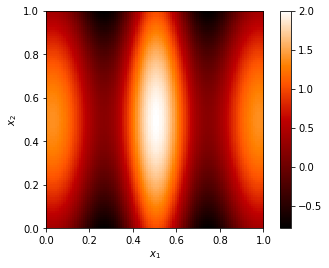

In [5]:
# Target function plot

def f(x,y):
    v0 = np.cos(4.*np.pi*x)*np.exp(-4*(x-0.5)**2) + np.sin(1.*np.pi*y)
    return v0

resolution = 0.01

x0 = np.arange(0.,1., resolution)
x1 = np.arange(0.,1., resolution)

x0, x1 = np.meshgrid(x0, x1)
y0 = f(x0,x1)

img = plt.imshow(y0, interpolation='none', extent=[0.,1.,0.,1.])
#img.set_cmap('hot')
img.set_cmap('gist_heat')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

coordinates = np.array([x0.flatten(),x1.flatten()]).transpose()

Model: "typical_ann"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
OSAM_P0 (Dense)              (None, 120)               360       
_________________________________________________________________
OSAM_F0 (Dense)              (None, 1)                 120       
_________________________________________________________________
Inner_Functions (Dense)      (None, 3)                 360       
_________________________________________________________________
Projected_Inner_Res (Dense)  (None, 1)                 3         
_________________________________________________________________
Sigmoid (Activation)         (None, 3)                 0         
_________________________________________________________________
Outer_OSAM_P0 (Dense)        (None, 180)               720       
_________________________________________________________________
Outer_OSAM_F0 (Dense)        (None, 1)                 

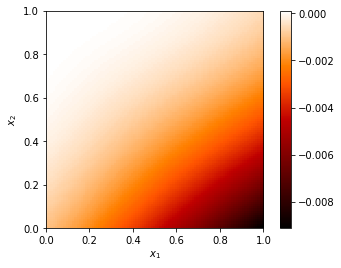

In [6]:
# Initialise a model
# n,m,r,k,u0,h0
n   = 2
m   = 1
r   = 4
k   = 3
h   = 0.

model = typical_ann(n,m,r,k,h)

model.construct()


# Print model summary
model.summary()

# Adjust weights for testing purposes, comment out otherwise
#weights = model.get_weights()



# Change index value to inspect the model
#index = 73 #change this value
#weights[2][index] = 1.
#model.set_weights(weights)


output1 = model.predict(coordinates).reshape(100,100)

img = plt.imshow(output1, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [7]:
# Data Generation 
# randomly and uniformly sampled 


rs = np.random.RandomState(16989)

#train_inputs = np.random.rand(10000,2)
train_inputs = rs.rand(10000,2)

z0 = train_inputs[:,0]
z1 = train_inputs[:,1]

train_output = f(z0,z1)

In [8]:
#Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss=tf.keras.losses.mean_squared_error,metrics=['mse'])

In [10]:
model.fit(train_inputs, train_output, epochs=40,verbose=1,callbacks=[tensorboard_callback])

Train on 10000 samples
Epoch 1/40
10000/10000 [==============================] - 4s 407us/sample - loss: 0.5050 - mse: 0.5050
Epoch 2/40
10000/10000 [==============================] - 2s 249us/sample - loss: 0.3696 - mse: 0.3696
Epoch 3/40
10000/10000 [==============================] - 3s 291us/sample - loss: 0.3249 - mse: 0.3249
Epoch 4/40
10000/10000 [==============================] - 3s 295us/sample - loss: 0.3085 - mse: 0.3085
Epoch 5/40
10000/10000 [==============================] - 3s 270us/sample - loss: 0.2994 - mse: 0.2994
Epoch 6/40
10000/10000 [==============================] - 3s 280us/sample - loss: 0.2946 - mse: 0.2946
Epoch 7/40
10000/10000 [==============================] - 3s 253us/sample - loss: 0.2903 - mse: 0.2903
Epoch 8/40
10000/10000 [==============================] - 2s 212us/sample - loss: 0.2836 - mse: 0.2836
Epoch 9/40
10000/10000 [==============================] - 2s 219us/sample - loss: 0.2725 - mse: 0.2725
Epoch 10/40
10000/10000 [=========================

In [11]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 18973), started 0:48:23 ago. (Use '!kill 18973' to kill it.)

In [12]:
output2 = model.predict(coordinates).reshape(100,100)

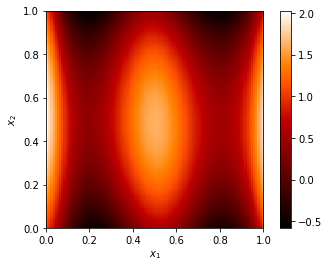

In [13]:
img = plt.imshow(output2, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [14]:
x_test = coordinates
y_test = y0.reshape(10000)

print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
10000/10000 [==============================] - 2s 168us/sample - loss: 0.0953 - mse: 0.0953
test loss, test acc: [0.09527758097648621, 0.095277585]


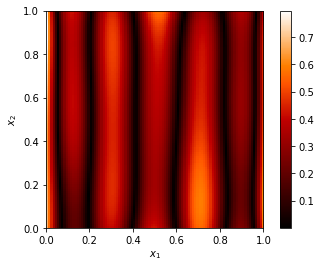

In [15]:
img = plt.imshow(np.abs(output2-y0), interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [16]:
y_new = y0.copy()
y_new[44:55,44:55] = 0.

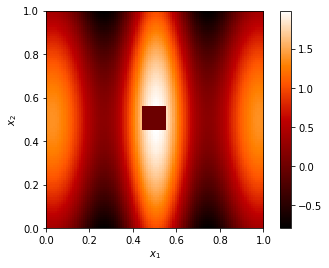

In [17]:
img = plt.imshow(y_new, interpolation='none', extent=[0.,1.,0.,1.])
#img.set_cmap('hot')
img.set_cmap('gist_heat')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [18]:
# New Data
k = 10000

rs2 = np.random.RandomState(13989)

train_inputs_2 = 0.11*rs2.rand(k,2)+0.44
#train_inputs_2 = 0.11*np.random.rand(k,2)+0.44

train_output_2 = np.ones(k)*0.

In [19]:
model.fit(train_inputs_2, train_output_2, epochs=2,verbose=1)

Train on 10000 samples
Epoch 1/2
10000/10000 [==============================] - 3s 254us/sample - loss: 0.0422 - mse: 0.0422
Epoch 2/2
10000/10000 [==============================] - 4s 354us/sample - loss: 8.6688e-04 - mse: 8.6688e-04


In [20]:
output3 = model.predict(coordinates).reshape(100,100)

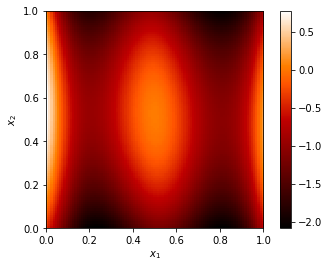

In [21]:
img = plt.imshow(output3, interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [22]:
x_test = coordinates
y_test = y_new.reshape(10000)

print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
10000/10000 [==============================] - 1s 129us/sample - loss: 2.1930 - mse: 2.1930
test loss, test acc: [2.192956117248535, 2.1929562]


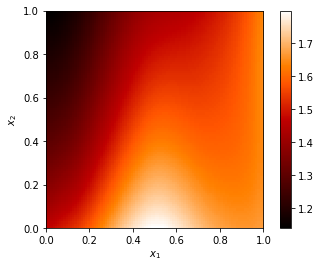

In [23]:
img = plt.imshow(np.abs(output3-output2), interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

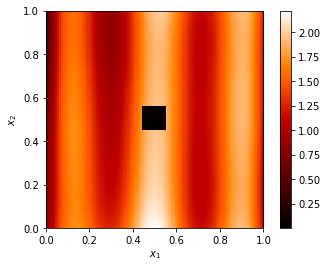

In [24]:
img = plt.imshow(np.abs(output3-y_new), interpolation='none', extent=[0.,1.,0.,1.])
img.set_cmap('hot')
img.set_cmap('gist_heat')
#img.set_cmap('summer')
plt.colorbar()
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

#plt.axis('off')
plt.show()

In [25]:
images_to_plot = [y0,output2,y_new,output3,np.abs(output3-output2)]

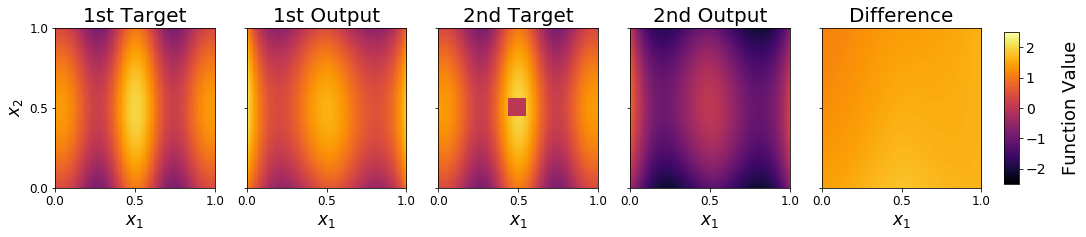

In [26]:
num_rows = 1
num_cols = 1
interpol = 'none' # 'nearest'
xticks = [0,0.5,1] #[0,0.25,0.5,0.75,1]
yticks = [0,0.5,1]
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][2] # 'inferno'
subplot_titles = ['1st Target','1st Output','2nd Target','2nd Output','Difference'] #['a','b','c','d','e']

fig, axs = plt.subplots(1, 5, sharex='col', sharey='row',figsize=(20,4))
#fig.tight_layout()

for col in range(5):    
    ax = axs[col]
    ax.set_title(subplot_titles[col],fontsize=20)
    ax.set_aspect(1)
    ax.set_xlabel(r'$x_{1}$',fontsize=17)
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', which='major', labelsize=12)
    
    if col==0:
        ax.set_ylabel(r'$x_{2}$',fontsize=17)
        ax.set_yticks(yticks)
        ax.tick_params(axis='y', which='major', labelsize=12)
    pcm = ax.imshow(images_to_plot[col], cmap=cmaps, interpolation='none', extent=[0.,1,0.,1.])
    #pcm.set_clim(np.min(images_to_plot),np.max(images_to_plot))
    pcm.set_clim(-2.5,2.5)
    
#cb = fig.colorbar(pcm, ax=axs, shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1, 1.5, 2], pad=0.02, aspect=10)
cb = fig.colorbar(pcm, ax=axs, shrink=0.7, pad=0.02, aspect=10)
#cb.set_label(r'$y(x_{1}, x_{2})$', labelpad=10, size=20)
cb.set_label(r'Function Value', labelpad=15, size=18)
cb.ax.tick_params(labelsize=14)

fig.savefig("KASAM_Paper_Two_Var_Results/typical_neural_ann.png", 
            close = True, verbose = True, dpi=500,bbox_inches='tight')

plt.show()